<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_83_1_ML_Intro_Solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepChem을 이용한 머신러닝 이해

# 용해도 예측
- 물질이 용매에 포화상태까지 녹을 수 있는 한도 ( - log(solubility) measured in moles/liter)
- 머신러닝의 동작 이해 (X로부터 y를 예측하는 모델 이해)
- chemical formula(X)로부터 용해도(y)를 예측
- 알려진 실제 화합물의 용해도로부터,유사한 화합물의 용해도를 예측하는 데 사용
- DeepChem 라이브러리 사용법
 - MoleculeNet 사용

## 데이터
- 존 델라니가 2004년에 발표한 논문 데이터

## 모델
- 랜덤 포레스트
 - CircularFingerprint 사용
- 그래프 컨볼류션 네트워크
 - featurizer='GraphConv' 사용
 - 분자의 SMILES를 그래프 합성곱 모델용으로 선택


# Import

In [ ]:
!pip install deepchem
import deepchem as dc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 14.2 MB/s 
     |████████████████████████████████| 36.8 MB 35 kB/s 


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

import tempfile
from itertools import islice
from IPython.display import Image, display
from deepchem.utils.data_utils import load_from_disk  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# 데이터

- SMILES, 용해도 등 분자특성을 포함한 csv 파일 다운로드
 - wget 또는 curl 사용
- 여기서는 `smiles` 와 `Measured log-solubility in mols/liter` 컬럼만 사용한다

In [ ]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2022-09-22 00:41:58--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.004s  

2022-09-22 00:41:59 (21.0 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [ ]:
# pandas read_csv()와 같은 역할을 수행하는 함수 (데이터프레임으로 읽는다)
from deepchem.utils.data_utils import load_from_disk  

dataset = load_from_disk("delaney-processed.csv")
print(dataset.shape)
dataset[:3]

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


## 데이터 탐색 (EDA)

In [ ]:
# 이미지 파일들을 출력하는 함수 정의
def display_images(filenames):
    for file in filenames:
      display(Image(file))

# mol 객체들을 입력으로 받아 이미지 파일을 만들고 파일의 리스트를 리턴하는 함수
# test0.png, test1.png, test2.png, test3.png, test4.png 등으로 생성

def mols_to_pngs(mols, basename="test"):
    filenames = []
    for i, mol in enumerate(mols):
        # filename = "%s%d.png" % (basename, i)
        filename = basename+str(i)+".png"
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

- dataset의 상위 N개 분자들을 시각화

In [ ]:
num_to_display = 3  # N
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))

molecules

In [ ]:
# 이미지 파일 만들기    
f_names = mols_to_pngs(molecules)
f_names

['test0.png', 'test1.png', 'test2.png']

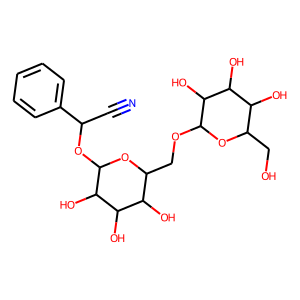

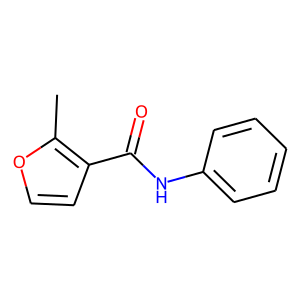

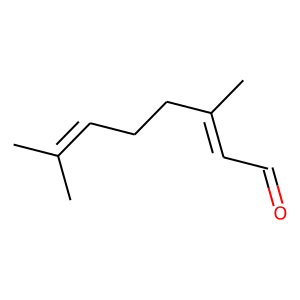

In [ ]:
# 이미지 파일 출력하기
display_images(f_names)

- 하나의 이미지만 출력하려면 mol 객체를 바로 그릴 수 있다
 - Chem.MolFromSmiles() 사용


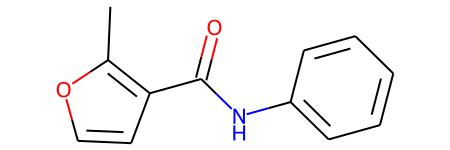

In [ ]:
Chem.MolFromSmiles(dataset["smiles"][1])

- 타겟 변수 `logS` 분포 보기

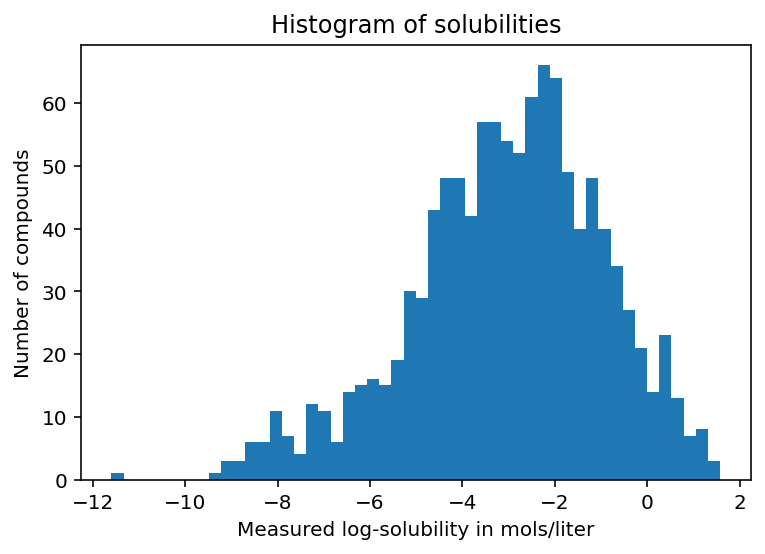

In [ ]:
solubilities = np.array(dataset["measured log solubility in mols per litre"])
plt.hist(solubilities, 50)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.show()

## 특성화 (Featurization)

- 화합물 특성의 표현 방법을 선택 `featurization`(특성화)
- `SMILES`로부터 특성값을 생성하는 방법으로 `ECPF`를 사용
- CSVLoader 클래스의 featurize()를 사용한다
 - `dc.feat` 모듈의 `CircularFingerprint` 클래스 사용
- create_dataset()으로 DiskDataset을 만든다
 - X, y, w, task, ids 등을 포함하는 데이터셋

In [ ]:
featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], feature_field="smiles",
      featurizer=featurizer)
data_FP = loader.create_dataset("delaney-processed.csv")

In [ ]:
data_FP

<DiskDataset X.shape: (1128, 1024), y.shape: (1128, 1), w.shape: (1128, 1), task_names: ['measured log solubility in mols per litre']>

In [ ]:
data_FP.X[0,:30]

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
data_FP.y[:5]

array([[-0.77],
       [-3.3 ],
       [-2.06],
       [-7.87],
       [-1.33]])

In [ ]:
data_FP.w[:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
data_FP.ids[:5]

array(['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ',
       'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)',
       'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1'], dtype=object)

## 데이터 분할
- dc.splits에서 다양한 분할 방법을 제공
 - 아래에서는 ScaffoldSplitter를 사용

In [ ]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(data_FP)

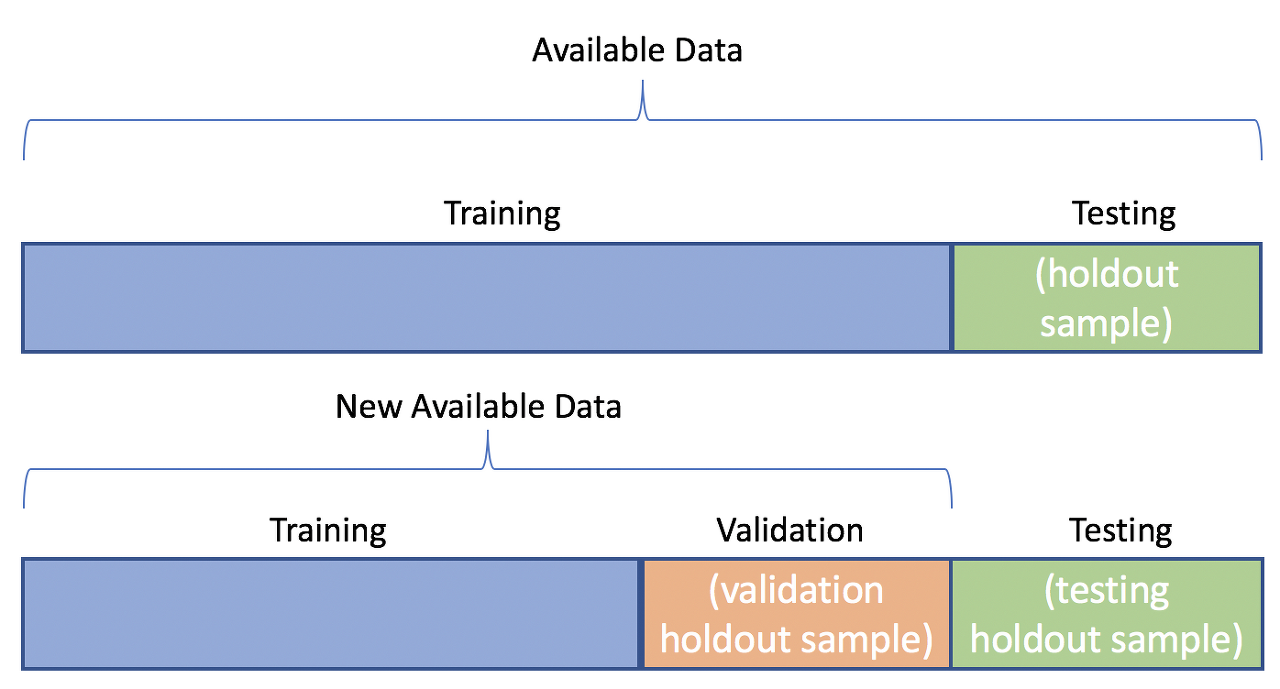

In [ ]:
train_dataset.ids[:5]

array(['CC(C)=CCCC(C)=CC(=O)', 'CCCC=C', 'CCCCCCCCCCCCCC', 'CC(C)Cl',
       'CCC(C)CO'], dtype=object)

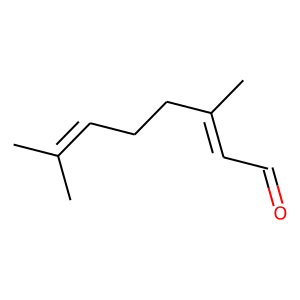

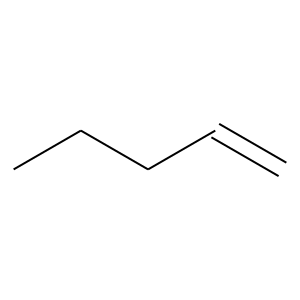

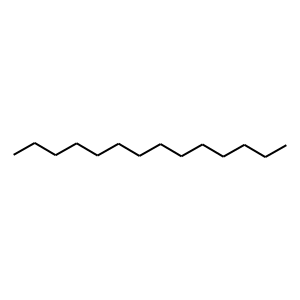

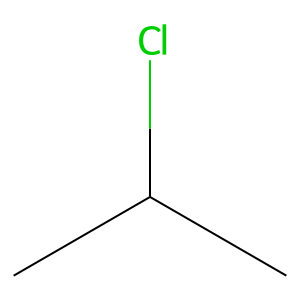

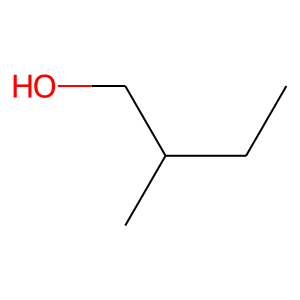

In [ ]:
# 시각화 함수를 사용하여 일부 Train 데이터 시각화
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
display_images(mols_to_pngs(train_mols[:5], basename="train"))

# 스케일링
- 훈련데이터를 기준으로 스케일러를 만들고, 이후 검증 및 테스트 데이터도 같은 스케일러를 적용한다

In [ ]:
# 표준 스케일링 수행
transformers = [
dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

In [ ]:
train_dataset

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

In [ ]:
valid_dataset

<DiskDataset X.shape: (113, 1024), y.shape: (113, 1), w.shape: (113, 1), ids: ['Nc1ncnc2nc[nH]c12 ' 'Nc1nc(O)nc2nc[nH]c12 '
 'Fc1cccc(F)c1C(=O)NC(=O)Nc2cc(Cl)c(F)c(Cl)c2F ' ...
 'OC(Cn1cncn1)(Cn2cncn2)c3ccc(F)cc3F '
 'FC(F)(F)c1cccc(c1)N2CC(CCl)C(Cl)C2=O' 'CC1(C)CON(Cc2ccccc2Cl)C1=O'], task_names: ['measured log solubility in mols per litre']>

# 램덤포레스트 모델
-`deepChem`은 `SklearnModel`을 통해서 `scikit-learn` 의 모델들도 지원한다

In [ ]:
from sklearn.ensemble import RandomForestRegressor
sklearn_model = RandomForestRegressor()

# sklearn 모델을 deepchem models로 변경
model = dc.models.SklearnModel(sklearn_model)

#train_dataset에 포함된 X, w, y값을 사용하여 모델 훈련
model.fit(train_dataset)

## 모델 학습과 성능 평가
- `deepchem`의 `Evaluator` 객체의 `compute_model_performance()`로 평가

In [ ]:
from deepchem.utils.evaluate import Evaluator
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
metric2 = dc.metrics.Metric(dc.metrics.rms_score)

evaluator = Evaluator(model, valid_dataset, transformers)
scores = evaluator.compute_model_performance([metric1, metric2])
print(scores)

{'r2_score': 0.1796052574195769, 'rms_score': 3.7005354837112736}


## 모델 최적화
- 하이퍼 파라미터 튜닝 수행
- model_dir은 dc.models.SklearnModel 함수의 인자로 다른 디렉토리에 생성한 모델이 있는 경우에 불러오기 위한 인자임

In [ ]:
def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  sklearn_model = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(sklearn_model, model_dir)

#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [50, 100],
    "max_features": [0.1, 0.15, 0.2],
    "max_depth" : [17, 19, 21]
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)

# 최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 리턴한다
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [ ]:
#최고 성능을 보이는 모델 하이퍼파라미터 출력
print(best_rf)
#탐색할때 사용한 하이퍼파라미터의 최적 값 출력
print(best_rf_hyperparams)
#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

{'n_estimators': 50, 'max_features': 0.2, 'max_depth': 21}
{'_max_depth_17_max_features_0.100000_n_estimators_50': 0.19297662755598866, '_max_depth_19_max_features_0.100000_n_estimators_50': 0.19626822893921347, '_max_depth_21_max_features_0.100000_n_estimators_50': 0.25039590741714135, '_max_depth_17_max_features_0.150000_n_estimators_50': 0.23792145267642573, '_max_depth_19_max_features_0.150000_n_estimators_50': 0.1936543189656066, '_max_depth_21_max_features_0.150000_n_estimators_50': 0.21006747851170293, '_max_depth_17_max_features_0.200000_n_estimators_50': 0.21013753023445714, '_max_depth_19_max_features_0.200000_n_estimators_50': 0.21255792752630642, '_max_depth_21_max_features_0.200000_n_estimators_50': 0.2586900008228774, '_max_depth_17_max_features_0.100000_n_estimators_100': 0.23283474551286865, '_max_depth_19_max_features_0.100000_n_estimators_100': 0.23748333923013198, '_max_depth_21_max_features_0.100000_n_estimators_100': 0.25227847284088767, '_max_depth_17_max_features

In [ ]:
# 최대 value 찾기
max(all_rf_results.values())

0.2586900008228774

In [ ]:
# 최대 value를 갖는 키 찾기
max(all_rf_results, key=all_rf_results.get)

'_max_depth_21_max_features_0.200000_n_estimators_50'

# 그래프 컨볼루션 모델
- load_delaney() 함수를 사용하여 데이터를 다운로드하면서 featurizer 옵션을 선택
 - 아래는 mol_graphs.ConvMol 표현법을 선택함

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [ ]:
train_dataset.X[0]

## 모델 학습과 성능 평가

In [ ]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
model.fit(train_dataset, nb_epoch=100)
metric1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric1, metric2], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric1, metric2], transformers))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(333,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(333, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(1052,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16

Training set score: {'pearson_r2_score': 0.9248767517050811, 'r2_score': 0.8325383281988731}
Test set score: {'pearson_r2_score': 0.7063778138428675, 'r2_score': 0.5568566912591739}


- R2 점수로 0.55를 얻었다

## 샘플 테스트 데이터에 대한 예측

In [ ]:
solubilities = model.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-1.6170025] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[1.0372946] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.50206274] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.8824666] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.2199157] [-0.52891635] C1=Cc2cccc3cccc1c23
[1.8410249] [1.10168349] CC1CO1
[-0.28628048] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.641102] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.6285328] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[-0.08722293] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[-0.37511274] [-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[0.9463018] [-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[0.57584983] [-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-0.5700152] [-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.42151392] [-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-0.24576369] [-0.73213651] c1ccc2c(c1)sc3ccccc23
[-0.86621445] [-1.27744393] CC23Cc1cno

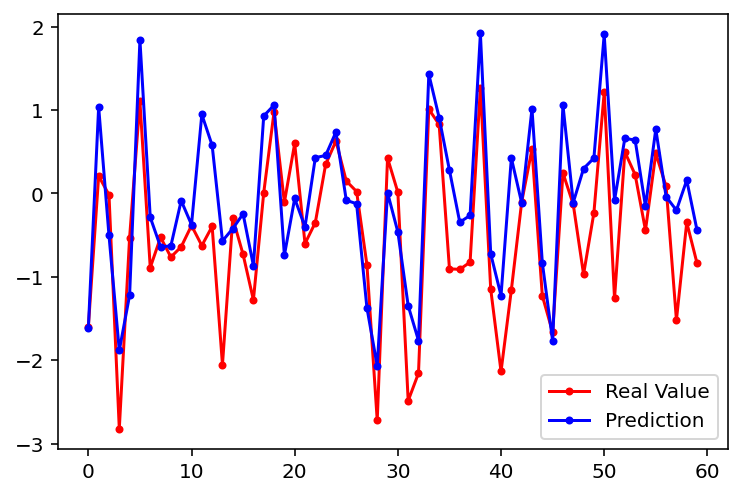

In [ ]:
# 60개의 테스트 샘플만 비교했다
plt.plot(test_dataset.y[:60], "r.-", label='Real Value')
plt.plot(solubilities[:60], "b.-",  label='Prediction')
plt.legend()

## 임의의 샘플에 적용해보기

In [ ]:
# from rdkit import Chem

smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = model.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.4545161]

Molecule: CCOC(=O)CC
Predicted solubility: [1.7437634]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [0.02791643]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [-0.2922493]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.59440154]


## ConvMol 이해

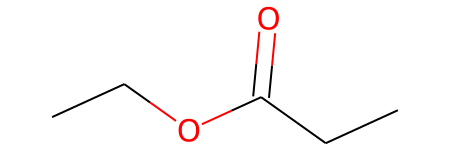

In [ ]:
# 위의 샘플에서 두번째 분자 보기
Chem.MolFromSmiles("CCOC(=O)CC")

In [ ]:
# ConvMol 특성의 구조 (원자가 7이고, 특성 벡터수가 75임)
x[1].atom_features.shape

(7, 75)

In [ ]:
x[1].get_atom_features()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.

In [ ]:
# 7개 원자의 인접 노드 번호들 보기
x[1].get_adjacency_list()

[[3], [6], [5], [0, 4], [3, 6], [6, 2], [4, 1, 5]]

In [ ]:
print(x[1].get_deg_adjacency_lists())

[array([], shape=(0, 0), dtype=int32), array([[3],
       [6],
       [5]], dtype=int32), array([[0, 4],
       [3, 6],
       [6, 2]], dtype=int32), array([[4, 1, 5]], dtype=int32), array([], shape=(0, 4), dtype=int32), array([], shape=(0, 5), dtype=int32), array([], shape=(0, 6), dtype=int32), array([], shape=(0, 7), dtype=int32), array([], shape=(0, 8), dtype=int32), array([], shape=(0, 9), dtype=int32), array([], shape=(0, 10), dtype=int32)]


In [ ]:
for i in range(4):
  print(x[1].get_deg_adjacency_lists()[i])

[]
[[3]
 [6]
 [5]]
[[0 4]
 [3 6]
 [6 2]]
[[4 1 5]]


In [ ]:
x[1].get_deg_slice()

array([[0, 0],
       [0, 3],
       [3, 3],
       [6, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)